# Assignment III
* Leoni Mota Loris

* At first, Load the data.

In [2]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import random
import matplotlib.pyplot as plt
import subprocess
import os, glob
import sys

In [3]:
PROTEIN = './protein'
ANALYZE = './analyze'
XYZPDB = './xyzpdb'
if 'WIN' in sys.platform:
    PROTEIN = PROTEIN[1:]+'.exe'
    ANALYZE = ANALYZE[1:]+'.exe'
    XYZPDB = XYZPDB[1:]+'.exe'

In [4]:
from collections import namedtuple

Atom = namedtuple('Atom', ['name', 'element', 'aminoacid', 'x', 'y', 'z', 'h', 'residue_seq_number'])

Atom.parse_name = lambda string: string[12:16].strip()
Atom.parse_element = lambda string: string[12] if len(string.strip()) < 78 \
                     else string[76:78].strip()
Atom.parse_aminoacid = lambda string: string[17:20].strip()
Atom.parse_x = lambda string: float(string[30:38].strip())
Atom.parse_y = lambda string: float(string[38:46].strip())
Atom.parse_z = lambda string: float(string[46:54].strip())
Atom.parse_residue_seq_number = lambda string: int(string[23:30].strip())

Atom.parse = lambda string: Atom(
    Atom.parse_name(string), Atom.parse_element(string), Atom.parse_aminoacid(string),
    Atom.parse_x(string), Atom.parse_y(string), Atom.parse_z(string), 1,Atom.parse_residue_seq_number(string))

In [5]:
def read_molecule(path):
    atoms = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('ATOM'):
                try:
                    atoms.append(Atom.parse(line))
                except Exception as e:
                    print(e)
    return pd.DataFrame(atoms)

## Question 1

## a)

* I) First we need to map the sequence of characters as in:

**TTCCPSIVARSNFNVCRLPGTPEAICATYTGCIIIPGATTCPGDYAN**
to a sequence of amino acids 

* II) And then, infer the position of each atom of the amino acid from a standard reference ($\alpha$ carbon) 


* III) Infer the position of multiple amino acids based on the peptide bond.

#### I) map the sequence of characters

In [6]:
aminoacid_mapping = {'T': 'THR', 'C': 'CYS', 'P': 'PRO', 'S': 'SER', 'I': 'ILE', 'Q': 'GLN', 'H': 'HIS', 
                     'V': 'VAL', 'A': 'ALA', 'R': 'ARG', 'N': 'ASN', 'F': 'PHE', 'K': 'LYS',
                     'L': 'LEU', 'G': 'GLY', 'E': 'GLU', 'D': 'ASP', 'Y': 'TYR', 'M': 'MET'}
    
def map_to_aminoacids(sequence):
    return list(map(lambda char: aminoacid_mapping[char], sequence))

In [7]:
molecule_name = 'test'
aminoacids_names = map_to_aminoacids('MTKQEKTALNMARFIRSQTLTLLEKLNELDADEQADICESLHDHADELYRSCLARFGDDGENL')

______________________________________________________________________________________________________________
______________________________________________________________________________________________________________
______________________________________________________________________________________________________________
______________________________________________________________________________________________________________
    

In [8]:
def load_aminoacids():
    return list(map(lambda aminoacid_name: read_molecule('assets/' + aminoacid_name + '.pdb'), aminoacids_names))

In [9]:
aminoacids = load_aminoacids()

In [10]:
display(aminoacids[0])

,name,element,aminoacid,x,y,z,h,residue_seq_number
0,N,,MET,0.071,-0.215,0.000,1,1
1,CA,,MET,1.519,-0.024,0.000,1,1
2,C,,MET,1.871,1.444,0.000,1,1
3,O,,MET,1.002,2.328,0.000,1,1
4,CB,,MET,2.146,-0.745,-1.225,1,1
5,CG,,MET,1.973,-2.278,-1.266,1,1
6,SD,,MET,2.996,-2.973,-2.575,1,1
7,CE,,MET,2.288,-4.625,-2.617,1,1
8,1H,1,MET,-0.615,0.619,0.000,1,1
9,2H,2,MET,-0.376,-1.198,0.000,1,1


______________________________________________________________________________________________________________
______________________________________________________________________________________________________________
______________________________________________________________________________________________________________
______________________________________________________________________________________________________________
    

#### III) Infer the position of multiple amino acids based on the peptide bond.


* After the nucleotilic attack the resonance delocalization of electrons in the peptide bond forces the creation of a plane where the atoms will be located (amide plan).

In [11]:
import numpy as np

def translation_matrix(delta_x, delta_y, delta_z, ref_x=.0, ref_y=.0, ref_z=.0):
    T = np.eye(4)
    T[0, -1], T[1, -1], T[2, -1] = delta_x - ref_x, delta_y - ref_y, delta_z - ref_z
    return T

def rotation_matrix(x_rotation_rad, y_rotation_rad, z_rotation_rad):
    Rx, Ry, Rz = np.eye(4), np.eye(4), np.eye(4)

    Rx[1, 1], Rx[1, 2], Rx[2, 1], Rx[2, 2] =\
        np.cos(x_rotation_rad), -np.sin(x_rotation_rad), np.sin(x_rotation_rad), np.cos(x_rotation_rad)
    
    Ry[0, 0], Ry[0, 2], Ry[2, 0], Ry[2, 2] =\
        np.cos(y_rotation_rad), np.sin(y_rotation_rad), -np.sin(y_rotation_rad), np.cos(y_rotation_rad)

    Rz[0, 0], Rz[0, 1], Rz[1, 0], Rz[1, 1] =\
        np.cos(z_rotation_rad), -np.sin(z_rotation_rad), np.sin(z_rotation_rad), np.cos(z_rotation_rad)

    return np.dot(np.dot(Rx, Ry), Rz)

def apply_transformation(transformation, df):
    df[['x', 'y', 'z', 'h']] = transformation.dot(df[['x', 'y', 'z', 'h']].T).T

def apply_rotation(transformation, df, atom_reference='N'):
    position = df[df.name == atom_reference].copy()
    apply_transformation(translation_matrix(-position.x, -position.y, -position.z), df)
    apply_transformation(transformation, df)
    apply_transformation(translation_matrix(position.x, position.y, position.z), df)


* Some utility functions for calculating the euclidean distance and the angle between two vectors:


$$distance = \sqrt{|(A - B)|}$$


$$cos(\alpha) = \frac{A \cdot B}{|A||B|}$$ 

In [12]:
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

def l2_norm(p):
    return np.sqrt(np.sum(p ** 2))

def get_angle_rad(a, b, normal_reference):
    negative = np.all(np.dot(np.cross(a, b), normal_reference) < 0)
    angle = np.arccos(((a).dot(b))/(l2_norm(a) * l2_norm(b))) 
    angle = angle if not np.isnan(angle) else .0
    return angle if not negative else -angle

In [13]:
def get_desired_omega(current_aminoacid):
    return 0.0 if 'PRO' in current_aminoacid.aminoacid.values else 180.0

def get_desired_OCN_angle(current_aminoacid):
    return 123.0 if 'PRO' in current_aminoacid.aminoacid.values else 123.5

def get_desired_CNCa_angle(current_aminoacid):
    return 126.0 if 'PRO' in current_aminoacid.aminoacid.values else 122.0

def get_desired_bond_length(current_aminoacid):
    return 1.32 if 'PRO' in current_aminoacid.aminoacid.values else 1.33

________________________________
* This function infers the position at which the amide nitrogen should be, so we can find a translation of the "next" aminoacid.


* It return a position that is equals to the rotation of the oxygen inside the plane C$\alpha$-C-N, and uses the length of the peptide bond (1.33Å or 1.32Å) and the Angle (123.5 or 123).

In [14]:
def get_desired_nitrogen_location(aminoacid):
    alpha_carbon = aminoacid[aminoacid.name == 'CA'][['x', 'y', 'z']].values.reshape(-1,)
    carboxyl_carbon = aminoacid[aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
    oxygen_double_bonded = aminoacid[aminoacid.name == 'O'][['x', 'y', 'z']].values.reshape(-1,)

    CO = oxygen_double_bonded - carboxyl_carbon
    CA = alpha_carbon - carboxyl_carbon

    plane_normal = np.cross(CO, CA)
    plane_vector_basis = np.array([
        np.cross(CO, plane_normal) / l2_norm(np.cross(CO, plane_normal)), 
        CO / l2_norm(CO), 
        plane_normal / l2_norm(plane_normal)]).T

    CO_new_norm = CO * get_desired_bond_length(aminoacid) / l2_norm(CO)
    CO_new_norm_plane = np.linalg.solve(plane_vector_basis, CO_new_norm)[:2]
    
    rotation_angle = np.radians(get_desired_OCN_angle(aminoacid))
    rotation_angle_matrix = np.array(
        [[np.cos(rotation_angle), -np.sin(rotation_angle)], 
         [np.sin(rotation_angle), np.cos(rotation_angle)]])

    CN_plane = CO_new_norm_plane @ rotation_angle_matrix
    CN = np.linalg.solve(np.linalg.inv(plane_vector_basis), np.array([CN_plane[0], CN_plane[1], 0]))
    N_desired = CN + carboxyl_carbon
    
    return np.pad(N_desired, (0, 1), 'constant', constant_values=1)

In [15]:
def get_normal_from_amide_plan(previous_aminoacid, current_aminoacid, terminal='C'):
    if terminal == 'C':
        alpha_carbon = previous_aminoacid[previous_aminoacid.name == 'CA'][['x', 'y', 'z']].values.reshape(-1,)
        carboxyl_carbon = previous_aminoacid[previous_aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
        oxygen_double_bonded = previous_aminoacid[previous_aminoacid.name == 'O'][['x', 'y', 'z']].values.reshape(-1,)
        C1 = oxygen_double_bonded - carboxyl_carbon
        C2 = alpha_carbon - carboxyl_carbon
    if terminal == 'N':
        last_carbon = current_aminoacid[current_aminoacid.name == 'CA'][['x', 'y', 'z']].values.reshape(-1,)
        nitrogen_amide = current_aminoacid[current_aminoacid.name == 'N'][['x', 'y', 'z']].values.reshape(-1,)
        carboxyl_carbon = previous_aminoacid[previous_aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
        C2 = last_carbon - nitrogen_amide
        C1 = carboxyl_carbon - nitrogen_amide
    return np.cross(C1, C2)

* The actual translations and rotations happens below:
    * We first translate the "next" aminoacid and then we do the rotations so the angles and distances can be as depicted below:
   
![assets/rotation.png](assets/pep.png)

* This method translates the `current_aminoacid` so its Nitrogen will be at the right spot for the peptide bond.

In [16]:
def translate_for_peptide_bond(previous_aminoacid, current_aminoacid):
    desired_nitrogen_location = get_desired_nitrogen_location(previous_aminoacid)
    current_nitrogen_location = current_aminoacid[current_aminoacid.name == 'N'][['x', 'y', 'z', 'h']].values.reshape(-1,)
        
    required_tranlation = desired_nitrogen_location - current_nitrogen_location
    
    required_tranlation_matrix = translation_matrix(required_tranlation[0], required_tranlation[1], required_tranlation[2])
    apply_transformation(required_tranlation_matrix, current_aminoacid)
    

* This method rotates the `current_aminoacid` so the normal of the plane $C\alpha_{i}-C_{i}=O_{i}$ and the normal of the plane $C-N_{i+1}-C\alpha_{i+1}$ can be aligned.

In [17]:
def rotate_for_normal_alignment(previous_aminoacid, current_aminoacid, desired_normal):
    dimensions_range = [[1, 2], [0, 2], [0, 1]]
    for i, dimensions in enumerate(dimensions_range):
        differences = {}
        _desired_normal = desired_normal[dimensions]        
        nitrogen_amide = current_aminoacid[current_aminoacid.name == 'N'][['x', 'y', 'z']].values.reshape(-1,)
        carboxyl_carbon = previous_aminoacid[previous_aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)

        for angle_to_rotate in range(360):
            rotation_angles = np.zeros(3); rotation_angles[i] = np.radians(angle_to_rotate)
            alpha_carbon = current_aminoacid[current_aminoacid.name == 'CA'][['x', 'y', 'z']].values.reshape(-1,)
            alpha_carbon = (rotation_matrix(*rotation_angles) @ np.append(alpha_carbon, 1))[:3]

            current_normal = np.cross(carboxyl_carbon - nitrogen_amide, alpha_carbon - nitrogen_amide)
            _current_normal = current_normal[dimensions]
            
            difference = l2_norm(np.cross(_current_normal, _desired_normal))
            difference += 0 if np.all(np.sign(_current_normal) == np.sign(_desired_normal)) else np.inf
            differences[np.radians(angle_to_rotate)] = difference

        apply_rotation(rotation_matrix(min(differences, key=differences.get), 0, 0), current_aminoacid)
    

def rotate_for_peptide_bond(previous_aminoacid, current_aminoacid):
    omega = get_desired_omega(current_aminoacid)
    assert omega == 180.0 or omega == 0.0, 'Omega angle should be either 0 or 180!'
    previous_normal = get_normal_from_amide_plan(previous_aminoacid, current_aminoacid, terminal='C')
    rotate_for_normal_alignment(previous_aminoacid, current_aminoacid, previous_normal if omega == 0.0 else -previous_normal)

* This method rotates the `current_aminoacid` in the direction of a normal of the plane $C\alpha_{i}-C_{i}=O_{i}$ stainding at the $N_i$ so the angle $C_i-N_{i+1}-C\alpha_{i+1}$ can be either 122 or 126 (*trans* / *cis*).

In [18]:
def rotate_for_CNCa_angle(previous_aminoacid, current_aminoacid):
    carboxyl_carbon = previous_aminoacid[previous_aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
    nitrogen_amide = current_aminoacid[current_aminoacid.name == 'N'][['x', 'y', 'z']].values.reshape(-1,)
    alpha_carbon = current_aminoacid[current_aminoacid.name == 'CA'][['x', 'y', 'z']].values.reshape(-1,)

    NC = carboxyl_carbon - nitrogen_amide
    NCa = alpha_carbon - nitrogen_amide

    plane_normal = np.cross(NCa, NC)
    plane_vector_basis = np.array([
        np.cross(NC, plane_normal) / l2_norm(np.cross(NC, plane_normal)), 
        NC / l2_norm(NC),
        plane_normal / l2_norm(plane_normal)]).T

    current_CNCa_angle_rad = get_angle_rad(NC, NCa, -plane_normal)
    desired_CNCa_angle_rad = np.radians(get_desired_CNCa_angle(current_aminoacid))
    
    needed_rotation_rad = desired_CNCa_angle_rad - current_CNCa_angle_rad
    
    new_current_aminoacid = current_aminoacid.copy()
    for i, atom in new_current_aminoacid.iterrows():
        new_current_aminoacid.loc[i, ['x', 'y', 'z']] =\
            np.linalg.solve(plane_vector_basis, np.array(atom.loc[['x', 'y', 'z']].values.reshape(-1,), dtype='float'))
    
    apply_rotation(rotation_matrix(0, 0, needed_rotation_rad), new_current_aminoacid)

    for i, atom in new_current_aminoacid.iterrows():
        new_current_aminoacid.loc[i, ['x', 'y', 'z']] =\
            np.linalg.solve(np.linalg.inv(plane_vector_basis), np.array(atom.loc[['x', 'y', 'z']].values.reshape(-1,), dtype='float'))
    
    new_alpha_carbon = new_current_aminoacid[new_current_aminoacid.name == 'CA'][['x', 'y', 'z']].values.reshape(-1,)
    NC = carboxyl_carbon - nitrogen_amide
    NCa = new_alpha_carbon - nitrogen_amide

In [19]:
def dehydration(aminoacid1, aminoacid2):
    aminoacid1 = aminoacid1[~aminoacid1.name.isin(['OC', 'HC'])]    

__________________________
* Functions to verify the constrains regarding angles and distances in the amide plane.

In [20]:
def check_peptide_bond_length(previous_aminoacid, current_aminoacid):
    a = previous_aminoacid[previous_aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
    b = current_aminoacid[current_aminoacid.name == 'N'][['x', 'y', 'z']].values.reshape(-1,)
    print('euclidean_distance for the peptide bond between %s and %s: %.2f' % 
          (previous_aminoacid.aminoacid[0], current_aminoacid.aminoacid[0], euclidean_distance(a, b)))
    
def check_OCN_angle(previous_aminoacid, current_aminoacid):
    c = previous_aminoacid[previous_aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1,)
    n = current_aminoacid[current_aminoacid.name == 'N'][['x', 'y', 'z']].values.reshape(-1,)
    o = previous_aminoacid[previous_aminoacid.name == 'O'][['x', 'y', 'z']].values.reshape(-1,)
    print('O-C-N Angle for the peptide bond between %s and %s:        %.2f' % 
          (previous_aminoacid.aminoacid[0], current_aminoacid.aminoacid[0], abs(180*get_angle_rad(o-c, n-c, (o-c))/np.pi)))

In [22]:
aminoacids_df = load_aminoacids()
for i in range(1, len(aminoacids_df)):
    current_aminoacid = aminoacids_df[i]
    previous_aminoacid = aminoacids_df[i - 1]
    
    dehydration(previous_aminoacid, current_aminoacid)
    translate_for_peptide_bond(previous_aminoacid, current_aminoacid)
    rotate_for_peptide_bond(previous_aminoacid, current_aminoacid)

print('last aminoacid:')
display(current_aminoacid)

KeyboardInterrupt: 

* We have all the atoms aligned accordingly. So, let's create string rows for the pdb.

In [21]:
def write_atom_to_file(atom_row, aminoacid_seq_number, fd):
    global atom_seq_number
    atom_seq_number += 1
    if 'H' not in atom_row[0]:
        atom_row.element = ''.join(filter(str.isalpha, atom_row[0]))[0]
        template_row =\
        'ATOM    '+\
        ('%d'%3).rjust(3)+\
        '  '+\
        ('%s'%atom_row[0]).rjust(3)+\
        ' '+\
        ('%s'%atom_row.aminoacid).rjust(3)+\
        ' A'+\
        ('%d'%aminoacid_seq_number).rjust(4)+\
        '    '+\
        ('%.3f'%atom_row.x).rjust(8)+\
        ('%.3f'%atom_row.y).rjust(8)+\
        ('%.3f'%atom_row.z).rjust(8)+\
        '  1.00  5.99           '+\
        ('%s\n'%atom_row.element)
        f.write(template_row)

In [25]:
atom_seq_number = 0

with open('assets/final_inferred_molecule.pdb', 'w') as f:
    for idx, aminoacid in enumerate(aminoacids_df):
        for atom_row in aminoacid.iterrows():
            write_atom_to_file(atom_row[1], idx+1, f)

with open("assets/final_inferred_molecule.pdb") as f:
    head = [next(f) for x in range(5)]
print('\n'.join(head))
print('...')

ATOM      3    N MET A   1       0.071  -0.215   0.000  1.00  5.99           N

ATOM      3   CA MET A   1       1.519  -0.024   0.000  1.00  5.99           C

ATOM      3    C MET A   1       1.871   1.444   0.000  1.00  5.99           C

ATOM      3    O MET A   1       1.002   2.328   0.000  1.00  5.99           O

ATOM      3   CB MET A   1       2.146  -0.745  -1.225  1.00  5.99           C

...


In [22]:
final_inferred_molecule = read_molecule('assets/final_inferred_molecule.pdb')

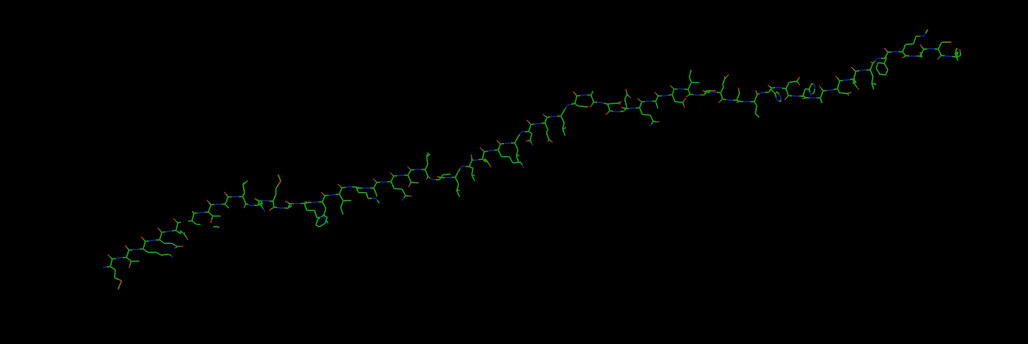

_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________
_________________________________________________________________________________


b) 

In [23]:
def create_xyz(aminoacids_sequence, phi, psi, molecule_name='test'):
    molecules_description = [("""\\n%s %.1f %.1f""" % (a, p, ps)) for a, p, ps in zip(aminoacids_sequence, phi, psi)]
    molecules_description = ''.join(molecules_description)
    args = """%s\\n%s\\ncharmm22.prm%s\\n\\n\\n""" % (molecule_name, molecule_name, molecules_description)
    yee = False
    while not yee:
        try:
            ps = subprocess.Popen(('printf', args), stdout=subprocess.PIPE)
            output = subprocess.check_output((PROTEIN), stdin=ps.stdout)
            ps.wait()
            yee = True
        except: pass
    

In [24]:
def get_potential_energy(file_name):
    yee = False
    while not yee:
        try:
            o = os.popen(
                    r'printf "%s\ncharmm22\nE\n" | %s | sed -n "s/Total Potential Energy : //p"' % (file_name, ANALYZE)
                ).read()
            return float(o.strip().split()[0].replace('D', 'e'))
        except :pass

In [25]:
def create_pdb(file):
    def add_atom_info(line):
        if len(line) > 14:
            atom = line[12:14].strip()[0]
            line = line + '  1.00  5.99           ' + atom
        return line
        
    ps = subprocess.Popen(('printf', "%s\\ncharmm22\\n" % file), stdout=subprocess.PIPE)
    output = subprocess.check_output((XYZPDB), stdin=ps.stdout)
    ps.wait()
    lines = open(file + '.pdb').read().splitlines()
    new_lines = list(map(add_atom_info, lines))
    open(file + '.pdb', 'w').write('\n'.join(new_lines))

In [26]:
l = len(aminoacids_names)
aminoacids_sequence, phi, psi = aminoacids_names, [0.0]*(l-1) + [0.03], [0.0]*(l-1) + [0.03]
for filename in glob.glob(molecule_name+'*'):
    try: os.remove(filename) 
    except: pass
create_xyz(aminoacids_sequence, phi, psi, molecule_name=molecule_name)
get_potential_energy(molecule_name)
# create_pdb(molecule_name)

13827.4108

In [27]:
def compute_loss(solution):
    for filename in glob.glob(molecule_name+'*'):
        try: os.remove(filename) 
        except: pass
    create_xyz(aminoacids_sequence, solution[:len(solution)//2], solution[len(solution)//2:], molecule_name=molecule_name)
    return get_potential_energy(molecule_name)
#     create_pdb(molecule_name)

def grouped(iterable, n):
    return zip(*[iter(iterable)]*n)

def weighted_sample(arr, p, n):
    from operator import itemgetter
    probs_and_elemnts = sorted([(np.random.random() * _p, element) for element, _p in zip(arr, p)],
                                key=itemgetter(0))[-n:]
    return list(map(lambda prob_elemnt: prob_elemnt[1], probs_and_elemnts))

def multi_point_crossover(ind1, ind2, n_cuts):
    import copy
    # https://pdfs.semanticscholar.org/1325/cb27eececd1016c1f543b3977febbda1c0cd.pdf
    cuts = random.sample(range(ind1.n_dimensions), n_cuts)
    new_individue1 = copy.deepcopy(ind1)
    new_individue2 = copy.deepcopy(ind2)
    for begin_cut, end_cut in grouped(cuts, 2):
        new_individue1.individual_solution[begin_cut:end_cut] = ind2.individual_solution[begin_cut:end_cut]
        new_individue2.individual_solution[begin_cut:end_cut] = ind1.individual_solution[begin_cut:end_cut]
    return [new_individue1, new_individue2]

from queue import Queue, Empty
from threading import Thread

def map_in_threads(function, arr, n_threads=10):
    que = Queue()
    threads = [Thread(target=lambda q, arg1: q.put(function(arg1)), args=(que, arg)) for arg in arr]
    [thread.start() for thread in threads]
    [thread.join() for thread in threads]
    return [que.get() for _ in range(que.qsize())]

In [28]:
class Individue:
    def __init__(self, n_dimensions, dimension_range, loss_function):
        self.n_dimensions = n_dimensions
        self._dimension_range = dimension_range
        self._loss_function = loss_function
        self.individual_solution = self._get_initial_solution()
        self.loss = np.inf
    
    def _get_initial_solution(self):
        _solution = np.mean(np.abs(self._dimension_range)) * np.random.uniform(-1, 1, self.n_dimensions)
        return np.clip(_solution, *self._dimension_range)
    
    @property
    def solution(self):
        return self.individual_solution
    
    def update_loss(self):
        self.loss = self._loss_function(self.individual_solution)
        
    def crossover(self, another_individual):
        return multi_point_crossover(self, another_individual, 10)
    
    def mutate(self, sigma, mutation_probability=0.1):
        self.individual_solution +=\
            sigma * np.random.randn(self.n_dimensions) * (np.random.rand(self.n_dimensions) > mutation_probability)
        self.individual_solution = np.clip(self.individual_solution , *self._dimension_range)
        
class GeneticAlgorithm:
    def __init__(self, population_size, n_dimensions, dimension_range, loss_function, reselection_rate=0.8):
        self._population_size = population_size
        self._n_reselected = int(reselection_rate * population_size)
        self._population = [Individue(n_dimensions, dimension_range, loss_function) for _ in range(population_size)]
        self._best_so_far = []
        self.global_losses = []
    
    def update_population_fitness(self):
        return map_in_threads(lambda individual: self._fitness_function(individual.solution), self._population)
    
    def natural_selection(self, population_individual_loss):
        how_far_from_the_worst = (np.max(population_individual_loss) - population_individual_loss)
        return weighted_sample(self._population, how_far_from_the_worst, self._n_reselected)
        
    def crossover(self, parent1, parent2):
        return parent1.crossover(parent2)
    
    def mutate_population(self, sigma):
        map_in_threads(lambda ind: ind.mutate(sigma), self._population)
        
    def get_population_individual_loss(self):
        return np.array(map_in_threads(lambda ind: ind.loss, self._population))
    
    def save_best_individue(self, global_loss):
        best = min(self._population, key=lambda i:abs(i.loss))
        self._best_so_far.append(best)
        self.global_losses.append(global_loss)
        
    def _create_is_it_finished(self):
        iteration = 0
        previous_population_loss = None
        def is_it_finished(eps=0.1, max_iteration=100):
            nonlocal iteration, previous_population_loss
            
            current_population_loss = np.mean(self.get_population_individual_loss())
            iteration += 1
            previous_population_loss = current_population_loss
            self.save_best_individue(current_population_loss)
            print('Iteration: %d, Loss: %.1f' % (iteration, current_population_loss))
            return iteration > max_iteration
        return is_it_finished

    def update_population_loss(self):
        map_in_threads(lambda ind: ind.update_loss(), self._population)
        
    def create_children(self, n_of_children):
        children = [self.crossover(self._population[i], self._population[i+1]) for i in range(n_of_children // 2)]
        return [item for sublist in children for item in sublist]

    def optimize(self, max_iteration=500):
        is_it_finished = self._create_is_it_finished()
        while not is_it_finished(max_iteration=max_iteration):
            self.update_population_loss()
            self._population = self.natural_selection(self.get_population_individual_loss())
            new_children = self.create_children(self._population_size - len(self._population))
            self._population.extend(new_children)
            self.mutate_population(sigma=5)

In [29]:
g = GeneticAlgorithm(80, len(aminoacids_names)*2, (-180.0, 180.0), compute_loss)

In [60]:
g.optimize()

Iteration: 1, Loss: inf
Iteration: 2, Loss: 257184243197017.5
Iteration: 3, Loss: 62497077550460824.0
Iteration: 4, Loss: 1770748102298784.8
Iteration: 5, Loss: 880791661014379.6
Iteration: 6, Loss: 12949579107885.9
Iteration: 7, Loss: 2501699319500000.0
Iteration: 8, Loss: 503828003761402.8
Iteration: 9, Loss: 149430557626148.5
Iteration: 10, Loss: 338912069458571584.0
Iteration: 11, Loss: 10042433201119.8
Iteration: 12, Loss: 15869900682172810.0
Iteration: 13, Loss: 185632187304470.2
Iteration: 14, Loss: 110236523645250.2
Iteration: 15, Loss: 282845061461159616.0
Iteration: 16, Loss: 9231242993650.2
Iteration: 17, Loss: 98074805232360.5
Iteration: 18, Loss: 7397167444918314.0
Iteration: 19, Loss: 42522616340096960.0
Iteration: 20, Loss: 331040435508291.8
Iteration: 21, Loss: 1415947754453346.5
Iteration: 22, Loss: 10477915515562588.0
Iteration: 23, Loss: 84904210517264.0
Iteration: 24, Loss: 7361535879095158.0
Iteration: 25, Loss: 4114663711059654.5
Iteration: 26, Loss: 3639901703498

Iteration: 206, Loss: 26791679166437.5
Iteration: 207, Loss: 5231286250000.0
Iteration: 208, Loss: 189696266817322304.0
Iteration: 209, Loss: 2748029012074.1
Iteration: 210, Loss: 43529825125000.0
Iteration: 211, Loss: 219139644287048.1
Iteration: 212, Loss: 548631568957976256.0
Iteration: 213, Loss: 1406422623072778.5
Iteration: 214, Loss: 136677677249672.5
Iteration: 215, Loss: 63297274832463.0
Iteration: 216, Loss: 877640380733028.9
Iteration: 217, Loss: 201899331175357.1
Iteration: 218, Loss: 2371085192629127.0
Iteration: 219, Loss: 403720802016932.8
Iteration: 220, Loss: 14141207822625000.0
Iteration: 221, Loss: 365609698401249984.0
Iteration: 222, Loss: 5683049033998713.0
Iteration: 223, Loss: 145111813125000.0
Iteration: 224, Loss: 2160014318268386.0
Iteration: 225, Loss: 3355814343419589.0
Iteration: 226, Loss: 6300070455002376192.0
Iteration: 227, Loss: 266892199166849.1
Iteration: 228, Loss: 17462449171494.5
Iteration: 229, Loss: 584989296707422.2
Iteration: 230, Loss: 518291

Iteration: 407, Loss: 553379002125000.0
Iteration: 408, Loss: 186109327204302.7
Iteration: 409, Loss: 1225506786961766.2
Iteration: 410, Loss: 16816466768250000.0
Iteration: 411, Loss: 91547308205807.7
Iteration: 412, Loss: 108919906500000.0
Iteration: 413, Loss: 334889622750000.0
Iteration: 414, Loss: 2395276409284677.5
Iteration: 415, Loss: 75556568000000.0
Iteration: 416, Loss: 17568757165000000.0
Iteration: 417, Loss: 568131944083784.6
Iteration: 418, Loss: 3974361436640678.5
Iteration: 419, Loss: 2841476990000000.0
Iteration: 420, Loss: 15778798278664499200.0
Iteration: 421, Loss: 873663831691025.8
Iteration: 422, Loss: 449373140375000.0
Iteration: 423, Loss: 10722287371875000.0
Iteration: 424, Loss: 48778111962272168.0
Iteration: 425, Loss: 106638923555328016384.0
Iteration: 426, Loss: 865833521464795.1
Iteration: 427, Loss: 243450084750000.0
Iteration: 428, Loss: 2627489024000000.0
Iteration: 429, Loss: 117986361375000.0
Iteration: 430, Loss: 3565132147625000.0
Iteration: 431, L

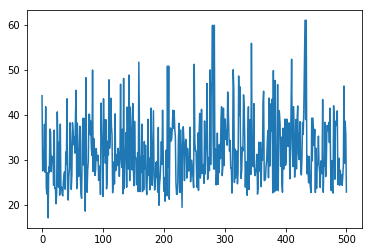

In [31]:
a = list(map(lambda a:a.loss, g._best_so_far))
plt.plot(np.log(a))

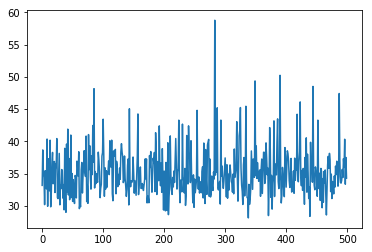

In [32]:
a = list(g.global_losses[1:])
plt.plot(np.log(a))

c) Compare RMSD

In [33]:
protein_to_be_compared = read_molecule('assets/1rop.pdb')
n_of_aminoacids = len(protein_to_be_compared.residue_seq_number.unique())

In [34]:
atom_seq_number=0
def write_atom_to_file(atom_row, fd):
    global atom_seq_number
    atom_seq_number += 1
    template_row =\
    'ATOM    '+\
    ('%d'%atom_seq_number).rjust(3)+\
    '  '+\
    ('%s'%atom_row[0]).rjust(3)+\
    ' '+\
    ('%s'%atom_row.aminoacid).rjust(3)+\
    ' A'+\
    ('%d'%atom_row.residue_seq_number).rjust(4)+\
    '    '+\
    ('%.3f'%atom_row.x).rjust(8)+\
    ('%.3f'%atom_row.y).rjust(8)+\
    ('%.3f'%atom_row.z).rjust(8)+\
    '  1.00  5.99           '+\
    ('%s\n'%atom_row.element)
    f.write(template_row)
    
def get_rmsd(file1, file2):
    o = os.popen(r'calculate_rmsd --no-hydrogen %s %s' % (file1, file2)).read()
    display(o)
    return float(o)

In [35]:
p1 = read_molecule('assets/1rop.pdb'); p1 = p1[(p1.name=='CA') & (p1.residue_seq_number<=n_of_aminoacids)]
with open('1rop.pdb', 'w') as f:
    p1.apply(lambda row: write_atom_to_file(row, f), axis=1)

p2 = read_molecule('assets/final_inferred_molecule.pdb'); p2 = p2[(p2.name=='CA') & (p2.residue_seq_number<=n_of_aminoacids)]
with open('final_inferred_molecule.pdb', 'w') as f:
    p2.apply(lambda row: write_atom_to_file(row, f), axis=1)

In [36]:
print(get_rmsd('final_inferred_molecule.pdb', '1rop.pdb'), 'Ångströns')

'48.226832269342964\n'

48.226832269342964 Ångströns


d)

In [37]:
molecule_name='comparing_rmsd'

try: os.remove(molecule_name) 
except: pass

phi_psi = g._best_so_far[-1].individual_solution
phi = phi_psi[:n_of_aminoacids]
psi = phi_psi[len(phi_psi)//2:len(phi_psi)//2+n_of_aminoacids]
sequence = aminoacids_sequence[:n_of_aminoacids]
create_xyz(sequence, phi, psi, molecule_name=molecule_name)
create_pdb(molecule_name)

FileNotFoundError: [Errno 2] No such file or directory: './xyzpdb'

In [ ]:
p1 = read_molecule('assets/1rop.pdb'); p1 = p1[(p1.name=='CA') & (p1.residue_seq_number<=n_of_aminoacids)]
with open('1rop.pdb', 'w') as f:
    p1.apply(lambda row: write_atom_to_file(row, f), axis=1)

p2 = read_molecule(molecule_name + '.pdb'); p2 = p2[p2.name=='CA']
with open(molecule_name + '.pdb', 'w') as f:
    p2.apply(lambda row: write_atom_to_file(row, f), axis=1)

In [ ]:
print(get_rmsd(molecule_name + '.pdb', '1rop.pdb'), 'Ångströns')

e) Ramachandran and secondary structure.

In [ ]:
def calculate_dihedral_angle(p1, p2, p3, p4):
    p1, p2, p3, p4 = np.array(p1), np.array(p2), np.array(p3), np.array(p4)
    
    b1 = -1.0 * (p2 - p1)
    b2 = p3 - p2
    b3 = p4 - p3
    
    b2 /= np.linalg.norm(b2)
    
    v = b1 - np.dot(b1, b2) * b2
    w = b3 - np.dot(b3, b2) * b2
    
    x = np.dot(v, w)
    y = np.dot(np.cross(b2, v), w)
    return np.degrees(np.arctan2(y, x))


def _infer_phi(c_previous, n_current, c_alpha_current, c_current):
    return calculate_dihedral_angle(c_previous, n_current, c_alpha_current, c_current)


def _infer_psi(n_current, c_alpha_current, c_current, n_next):
    return calculate_dihedral_angle(n_current, c_alpha_current, c_current, n_next)


def infer_phi_psi(protein):
    phi_psi = pd.DataFrame(data=None, columns=['amino', 'phi', 'psi'])    
    previous_aminoacid = None
    
    for i in protein.residue_seq_number.unique():
        current_aminoacid = protein[protein.residue_seq_number == i].copy()
        next_aminoacid = protein[protein.residue_seq_number == int(i)+1].copy() 
        next_aminoacid = next_aminoacid if not next_aminoacid.empty else None
        c_previous = previous_aminoacid[previous_aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1)\
                     if previous_aminoacid is not None else None
        n_current = current_aminoacid[current_aminoacid.name == 'N'][['x', 'y', 'z']].values.reshape(-1)
        c_alpha_current = current_aminoacid[current_aminoacid.name == 'CA'][['x', 'y', 'z']].values.reshape(-1)
        c_current = current_aminoacid[current_aminoacid.name == 'C'][['x', 'y', 'z']].values.reshape(-1)
        n_next = next_aminoacid[next_aminoacid.name == 'N'][['x', 'y', 'z']].values.reshape(-1)\
                 if next_aminoacid is not None else None

        
        phi = _infer_phi(c_previous, n_current, c_alpha_current, c_current) if previous_aminoacid is not None else None
        psi = _infer_psi(n_current, c_alpha_current, c_current, n_next) if next_aminoacid is not None else None
        
        previous_aminoacid = current_aminoacid
        
        
        
        
        new_phi_psi = pd.DataFrame(data={'amino': [current_aminoacid.aminoacid.iloc[0]], 
                                         'phi': [phi], 
                                         'psi': [psi]})  
        phi_psi = phi_psi.append(new_phi_psi, sort=True, ignore_index=True)
    return phi_psi

In [ ]:
inferred_phi_psi = infer_phi_psi(read_molecule(molecule_name + '.pdb')); inferred_phi_psi = inferred_phi_psi.fillna(0)
experimental_phi_psi = infer_phi_psi(read_molecule('assets/1rop.pdb')); experimental_phi_psi = experimental_phi_psi.fillna(0)

In [ ]:
def ramachandran(phi_psi, axis, label):
    axis.set_title(label)
    axis.hist2d(phi_psi.phi, phi_psi.psi, bins=(40, 40), cmap=plt.cm.Greys);
    axis.plot(np.zeros_like(phi_psi.phi), np.linspace(-180, 180, len(phi_psi.phi)))
    axis.plot(np.linspace(-180, 180, len(phi_psi.phi)), np.zeros_like(phi_psi.phi))
    axis.set_xlabel('$\Phi$')
    axis.set_ylabel('$\Psi$')
    axis.set_xlim([-190, 190])
    axis.set_ylim([-190, 190])
    axis.grid()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
plt.figure(figsize=(10, 10))
ramachandran(experimental_phi_psi, ax[0], 'Experimental protein')
ramachandran(inferred_phi_psi, ax[1], 'Inferred protein')

plt.show()

- Secondary structure

*When five or more consecutive amino acids have torsion angles in the $\alpha$-helical region of the Ramachandran plot, the hydrogen bonds typical of the $\alpha$-helix will form and the structure will snap into a very highly populated and finely focused area near '$\phi$ = 63.8°, $\psi$ = 41.1° (..) as 39% of all 237 384 amino acids were found here, in an area just 2% of the Ramachandran plot -89° < $\phi$ < -39°, -66° < $\psi$ < -16°*

______________
*The conformations of the amino acids in five of the six groups were surprisingly similar with respect to both the average and values (all within -130° < $\phi$ < -105° and 128° < $\psi$ < 147°) for the first five groups and the standard deviations (15...26°).*

- Source: HOVMOLLER S1, ZHOU T, OHLSON T. Conformations of amino acids in proteins. Acta Crystallogr D Biol Crystallogr

In [ ]:
alpha_helix_phi = (-89, -39)
alpha_helix_psi = (-66, -16)
beta_sheet_phi = (-130, -105)
beta_sheet_psi = (128, 147)

In [ ]:
def infer_secondary_structure(protein_df):
    secondary_structure = []
    for i, row in protein_df.iterrows():
        if alpha_helix_phi[0] < row.loc['phi'] < alpha_helix_phi[1] and\
           alpha_helix_psi[0] < row.loc['psi'] < alpha_helix_psi[1]:
            secondary_structure.append('H')
        elif beta_sheet_phi[0] < row.loc['phi'] < beta_sheet_phi[1] and\
             beta_sheet_psi[0] < row.loc['psi'] < beta_sheet_psi[1]:
            secondary_structure.append('B')
        else:
            secondary_structure.append('-')
    return secondary_structure

In [ ]:
print('Primary Structure:')
print('TTCCPSIVARSNFNVCRLPGTPEAICATYTGCIIIPGATCPGDYAN\n')
print('Experimental secondary Structure:')
print(''.join(infer_secondary_structure(experimental_phi_psi)))
print('Inferred secondary Structure:')
print(''.join(infer_secondary_structure(inferred_phi_psi)))